In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Clean Data from May 27 to June 23 

In [2]:
## Setup

In [3]:
# imports a library 'pandas', names it as 'pd'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mta_importer as mp


from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

In [4]:
print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)

Pandas version: 0.20.2
Numpy version: 1.12.1


In [5]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.options.display.float_format = '{:,.2f}'.format
#pd.set_option('display.precision',3)

In [6]:
# read data

#df = mp.mta_selector('06-03-17','06-30-17')
filelist = ['http://web.mta.info/developers/data/nyct/turnstile/turnstile_170624.txt',
            'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170617.txt',
            'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170610.txt',
            'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170603.txt'
           ]
for file_name in filelist:
    if file_name == filelist[0]:
        df = pd.read_csv(file_name)
    else:
        df = df.append(pd.read_csv(file_name))
df.head()



,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,00:00:00,REGULAR,6224816,2107317
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,04:00:00,REGULAR,6224850,2107322
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,08:00:00,REGULAR,6224885,2107352
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,12:00:00,REGULAR,6225005,2107452
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,16:00:00,REGULAR,6225248,2107513


In [7]:
cols = ['control_area', 'unit', 'scp', 'station', 'line_name',\
        'division', 'date', 'time', 'desc','cum_entries', 'cum_exits']

df.columns = cols
df.head()

,control_area,unit,scp,station,line_name,division,date,time,desc,cum_entries,cum_exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,00:00:00,REGULAR,6224816,2107317
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,04:00:00,REGULAR,6224850,2107322
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,08:00:00,REGULAR,6224885,2107352
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,12:00:00,REGULAR,6225005,2107452
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,16:00:00,REGULAR,6225248,2107513


In [8]:
df = df.reset_index(drop=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788214 entries, 0 to 788213
Data columns (total 11 columns):
control_area    788214 non-null object
unit            788214 non-null object
scp             788214 non-null object
station         788214 non-null object
line_name       788214 non-null object
division        788214 non-null object
date            788214 non-null object
time            788214 non-null object
desc            788214 non-null object
cum_entries     788214 non-null int64
cum_exits       788214 non-null int64
dtypes: int64(2), object(9)
memory usage: 66.1+ MB


In [10]:
# check contents of variables
print(df.shape)
print(df.desc.value_counts())
print(df.division.value_counts())

(788214, 11)
REGULAR       785406
RECOVR AUD      2808
Name: desc, dtype: int64
IRT    287131
IND    282446
BMT    160816
PTH     50524
SRT      5607
RIT      1690
Name: division, dtype: int64


In [11]:
# check turnstile's smallest set of uniquely identifiable variables
# result: a tunstile is unique by control area, scp and station

print(df[['control_area','scp','station']].drop_duplicates().shape)
print(df[['scp','station']].drop_duplicates().shape)
print(df[['control_area','scp','station','unit']].drop_duplicates().shape)


(4710, 3)
(4158, 2)
(4710, 4)


In [12]:
# add datetime variable
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format = '%m/%d/%Y %H:%M:%S')
df.datetime.describe()

count                  788214
unique                  51940
top       2017-06-20 20:00:00
freq                     2421
first     2017-05-27 00:00:00
last      2017-06-23 23:59:58
Name: datetime, dtype: object

In [22]:
df.sort_values(['control_area','scp','station','datetime'])\
.groupby(['control_area','scp', 'station'])['cum_entries']\
.shift(1).isnull().sum()

4710

In [28]:
# add shifted data
df[['shift_cum_entries','shift_cum_exits', 'shift_datetime']] = \
df.sort_values(['control_area','scp','station','datetime'])\
.groupby(['control_area','scp', 'station'])[['cum_entries','cum_exits','datetime']]\
.shift(1)

df['entries'] = df['cum_entries'] - df['shift_cum_entries']
df['exits'] = df['cum_exits'] - df['shift_cum_exits']
df = df.sort_values(['control_area','scp','station','datetime'])
df = df.reset_index(drop=True)
df.head()

,control_area,unit,scp,station,line_name,division,date,time,desc,cum_entries,cum_exits,datetime,shift_cum_entries,shift_cum_exits,shift_datetime,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,00:00:00,REGULAR,6195217,2098317,2017-05-27 00:00:00,nan,nan,NaT,nan,nan
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,04:00:00,REGULAR,6195240,2098318,2017-05-27 04:00:00,"6,195,217.00","2,098,317.00",2017-05-27 00:00:00,23.00,1.00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,08:00:00,REGULAR,6195256,2098347,2017-05-27 08:00:00,"6,195,240.00","2,098,318.00",2017-05-27 04:00:00,16.00,29.00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,12:00:00,REGULAR,6195346,2098432,2017-05-27 12:00:00,"6,195,256.00","2,098,347.00",2017-05-27 08:00:00,90.00,85.00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,16:00:00,REGULAR,6195518,2098491,2017-05-27 16:00:00,"6,195,346.00","2,098,432.00",2017-05-27 12:00:00,172.00,59.00


In [29]:
df.describe()

,cum_entries,cum_exits,shift_cum_entries,shift_cum_exits,entries,exits
count,"788,214.00","788,214.00","783,504.00","783,504.00","783,504.00","783,504.00"
mean,"38,331,041.34","30,843,482.04","38,328,794.80","30,842,740.14","6,325.00","4,147.11"
std,"204,998,952.32","184,566,808.97","204,990,982.59","184,562,239.29","2,939,348.53","2,483,152.29"
min,0.00,0.00,0.00,0.00,"-101,036,140.00","-33,597,403.00"
25%,"496,174.75","244,641.50","496,340.00","244,716.50",10.00,8.00
50%,"2,636,639.50","1,485,953.50","2,636,758.00","1,485,999.50",78.00,53.00
75%,"6,782,455.25","4,770,244.00","6,782,505.75","4,770,246.75",248.00,168.00
max,"2,130,465,074.00","2,087,386,867.00","2,130,465,074.00","2,087,386,867.00","1,621,023,313.00","2,038,811,878.00"


In [36]:
print('unique turnasile combinations', df[['control_area','scp','station','unit']].drop_duplicates().shape[0])
print('shift_cum_entries null values', df.shift_cum_exits.isnull().sum())
print('shift_cum_exits null values', df.shift_cum_exits.isnull().sum())
print('shift_datetime null values', df.shift_datetime.isnull().sum())

unique turnasile combinations 4710
shift_cum_entries null values 4710
shift_cum_exits null values 4710
shift_datetime null values 4710


In [27]:
df[['entries','exits']].describe()

,entries,exits
count,"783,504.00","783,504.00"
mean,"6,325.00","4,147.11"
std,"2,939,348.53","2,483,152.29"
min,"-101,036,140.00","-33,597,403.00"
25%,10.00,8.00
50%,78.00,53.00
75%,248.00,168.00
max,"1,621,023,313.00","2,038,811,878.00"


In [39]:
# describe negative/zero values
print('percentage of negative entries:', "{0:.3f}%".format(df[df.entries < 0].shape[0]/df.shape[0]*100))
print('percentage of zero entries:', "{0:.3f}%".format(df[df.entries == 0].shape[0]/df.shape[0]*100))
print('percentage of negative exits:', "{0:.3f}%".format(df[df.exits < 0].shape[0]/df.shape[0]*100))
print('percentage of zero entries:', "{0:.3f}%".format(df[df.exits == 0].shape[0]/df.shape[0]*100))

# - since negative number's percentage is small, we can take a look at the negative numbers to tell how the numbers are wrong
# - the zero recordings are likely to be from the station closing, or resetting of number
# - we can manually get a sense the outlieres of positive numbers by eyeballing the numbers


percentage of negative entries: 0.812%
percentage of zero entries: 14.968%
percentage of negative exits: 0.640%
percentage of zero entries: 14.679%


### Process negative numbers

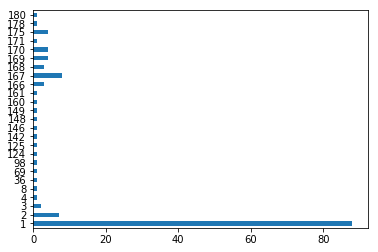

In [40]:
df[df.entries < 0].groupby(['station','control_area','scp'])['entries'].count().value_counts().sort_index().plot('barh')

# vertical axis is numbers of negative entries a turnstile has
# horizental is the count of the number of turnstile with a specific vertical value



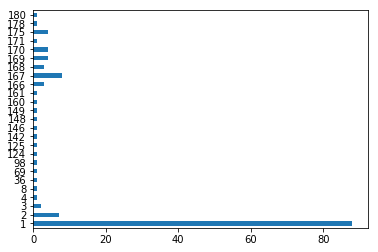

In [41]:
df[df.entries < 0].groupby(['station','control_area','scp'])['exits'].count().value_counts().sort_index().plot('barh')
# vertical axis is numbers of negative exits a turnstile has
# horizental is the count of the number of turnstile with a specific vertical value


In [43]:
# findings: 
# the negative negative entries/eixts either happen singularly (peak in 1), or happen for all periods (peaks in multiples of 41-45)

# for now, just process all negative numbers as null values 
# will need to refine the process later 

df.loc[df.entries < 0,'entries'] = np.nan
df.loc[df.exits < 0,'exits'] = np.nan


In [44]:
df[['entries','exits']].describe()

,entries,exits
count,"777,103.00","778,461.00"
mean,"6,883.06","4,360.30"
std,"2,945,486.56","2,490,575.33"
min,0.00,0.00
25%,11.00,9.00
50%,80.00,54.00
75%,250.00,169.00
max,"1,621,023,313.00","2,038,811,878.00"


### Process Outliers

In [45]:
# investigate outliers for entries

df[df.entries > 5000][['entries','cum_entries','shift_cum_entries']].sort_values('entries')

# it seems that there is a discontunity of data from 12K-ish to more than 60K in entries
# for now, process all entries numbers larger than 12K as null values


,entries,cum_entries,shift_cum_entries
332472,"6,316.00",13576291,"13,569,975.00"
334922,"7,155.00",2217322,"2,210,167.00"
335076,"8,807.00",2619718,"2,610,911.00"
334768,"9,187.00",31466,"22,279.00"
443902,"10,352.00",11462,"1,110.00"
443900,"10,630.00",11187,557.00
443905,"11,552.00",13704,"2,152.00"
441240,"65,925.00",92324,"26,399.00"
466456,"119,169.00",121167,"1,998.00"
465073,"150,679.00",258382,"107,703.00"


In [46]:
# investigate outliers for exits


#df[df.exits > 4000].sort_values('exits')
df[df.exits > 5000][['exits','cum_exits','shift_cum_exits']].sort_values('exits')

# it seems that there is a discontunity of data from 15K-ish to more than 27K in entries
# for now, process all exits numbers larger than 15K as null values

,exits,cum_exits,shift_cum_exits
196216,"5,512.00",57967162,"57,961,650.00"
334922,"5,524.00",1533570,"1,528,046.00"
441240,"5,782.00",7364,"1,582.00"
332931,"6,712.00",15135629,"15,128,917.00"
443900,"10,066.00",10105,39.00
333084,"10,486.00",23168999,"23,158,513.00"
334768,"11,438.00",35462,"24,024.00"
443902,"11,789.00",12052,263.00
443905,"12,071.00",12443,372.00
333848,"14,906.00",4964291,"4,949,385.00"


In [ ]:
# don't process outliers for now
#df.loc[df.entries > 12000,'entries'] = np.nan
#df.loc[df.exits > 15000,'exits'] = np.nan

In [49]:
df[['entries','exits']].describe()


,entries,exits
count,"777,103.00","778,461.00"
mean,"6,883.06","4,360.30"
std,"2,945,486.56","2,490,575.33"
min,0.00,0.00
25%,11.00,9.00
50%,80.00,54.00
75%,250.00,169.00
max,"1,621,023,313.00","2,038,811,878.00"


In [59]:
df.head()
df.to_csv('../../month_data_updated.csv')

In [61]:
df_new = pd.DataFrame.from_csv('../../month_data_updated.csv') 
df_new.describe()

/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,cum_entries,cum_exits,shift_cum_entries,shift_cum_exits,entries,exits
count,"788,214.00","788,214.00","783,504.00","783,504.00","777,103.00","778,461.00"
mean,"38,331,041.34","30,843,482.04","38,328,794.80","30,842,740.14","6,883.06","4,360.30"
std,"204,998,952.32","184,566,808.97","204,990,982.59","184,562,239.29","2,945,486.56","2,490,575.33"
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,"496,174.75","244,641.50","496,340.00","244,716.50",11.00,9.00
50%,"2,636,639.50","1,485,953.50","2,636,758.00","1,485,999.50",80.00,54.00
75%,"6,782,455.25","4,770,244.00","6,782,505.75","4,770,246.75",250.00,169.00
max,"2,130,465,074.00","2,087,386,867.00","2,130,465,074.00","2,087,386,867.00","1,621,023,313.00","2,038,811,878.00"


In [62]:
print('unique turnasile combinations', df_new[['control_area','scp','station','unit']].drop_duplicates().shape[0])
print('shift_cum_entries null values', df_new.shift_cum_exits.isnull().sum())
print('shift_cum_exits null values', df_new.shift_cum_exits.isnull().sum())
print('shift_datetime null values', df_new.shift_datetime.isnull().sum())

unique turnasile combinations 4710
shift_cum_entries null values 4710
shift_cum_exits null values 4710
shift_datetime null values 4710
